<img src="neid_thin.png" width="600"></img>

<h1><center>NEID Data Analysis Tutorial: Part 1 </center></h1>

<center><b>Author</b>: Arpita Roy (aroy@stsci.edu) | <b>Latest update</b>: June 10, 2021.</center>

--------------------------------------------------------------


## Table of contents
1. [Introduction](#intro)
2. [Open FITS File](#fits)
3. [Plot spectrum](#plotspec)
4. [Get Radial Velocity Values](#getrv)


### 1. Introduction <a class="anchor" id="intro"></a>
[NEID](https://neid.psu.edu/) is an extreme precision, high resolution [echelle](https://en.wikipedia.org/wiki/Echelle_grating) spectrograph that is designed for exoplanet discovery and characterization. This is a beginner's guide to NEID data analysis. In this tutorial, we will learn to look at NEID data, extract some key data products, and practice visualization techniques. 

The raw NEID data is automatically processed by the NEID Data Reduction Pipeline (DRP) which extracts, wavelength calibrates, and analyzes the data with a high level of precision. Here we will use Level 2 (L2) files produced by the DRP, which contain the observed spectra, as well as measured radial velocities. Detailed information about the NEID Data Reduction Pipeline is available [here](https://neid.ipac.caltech.edu/docs/NEID-DRP/).

Let's start by importing all the libraries we will need.

In [151]:
# Import file handling libraries:
import os
from glob import glob

# Import numpy and matplotlib:
import numpy as np
import matplotlib.pyplot as plt

# Import astropy for fits handling:
from astropy.io import fits

In [145]:
# You can set your plotting style of choice here
plt.style.use(['seaborn-darkgrid'])

### 2. Open FITS File <a class="anchor" id="fits"></a>
We have a sample observation of the Sun to look at. Let's open up the FITS file and explore its contents. Note the NEID file naming convention: neidL#_YYYYMMDDThhmmss.fits, where # is 0, 1, or 2 for the data level, and YYYYMMDDThhmmss is the timestamp corresponding to the beginning of the exposure. So this observation was taken on 8th February 2021, a little after 7pm UT.

In [5]:
hdul = fits.open('neidL2_20210208T191024.fits')

FITS files contain both data and metadata (information about the data). For NEID, the L2 FITS file is data cube containing several extensions with data, and corresponding headers with metadata about the observation conditions and processing that has already been performed. You can get a quick view of what is in the FITS file like this:

In [6]:
hdul.info()

Filename: neidL2_20210208T191024.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     740   ()      
  1  SCIFLUX       1 ImageHDU        12   (9216, 122)   float32   
  2  SKYFLUX       1 ImageHDU        12   (9216, 122)   float32   
  3  CALFLUX       1 ImageHDU        12   (9216, 122)   float32   
  4  SCIVAR        1 ImageHDU        12   (9216, 122)   float32   
  5  SKYVAR        1 ImageHDU        12   (9216, 122)   float32   
  6  CALVAR        1 ImageHDU        12   (9216, 122)   float32   
  7  SCIWAVE       1 ImageHDU      2253   (9216, 122)   float64   
  8  SKYWAVE       1 ImageHDU      2253   (9216, 122)   float64   
  9  CALWAVE       1 ImageHDU      2253   (9216, 122)   float64   
 10  TELLURIC      1 ImageHDU        12   (9216, 122)   float64   
 11  SKY           1 ImageHDU         8   ()      
 12  CCFS          1 ImageHDU       515   (804, 122)   float64   
 13  ACTIVITY      1 BinTableHDU     41   15R x 12C   [10A, D,

The names of the extensions should give you a good idea of what data is contained in them. The most important ones, as you are getting started are:
- `SCIFLUX` contains the flux from the science target (typically a star, in this case, the Sun)
- `SCIWAVE` contains the corresponding wavelength values per pixel in the spectrum

Let's see what those arrays look like.

In [8]:
flux = hdul['SCIFLUX'].data
wave = hdul['SCIWAVE'].data

print(flux.shape)
print(wave.shape)

(122, 9216)
(122, 9216)


These are both arrays with the same dimensions. They have 122 spectral orders, each with 9216 pixels across the large NEID CCD.

### 3. Plot Spectrum <a class="anchor" id="plotspec"></a>

First let's plot a single order.

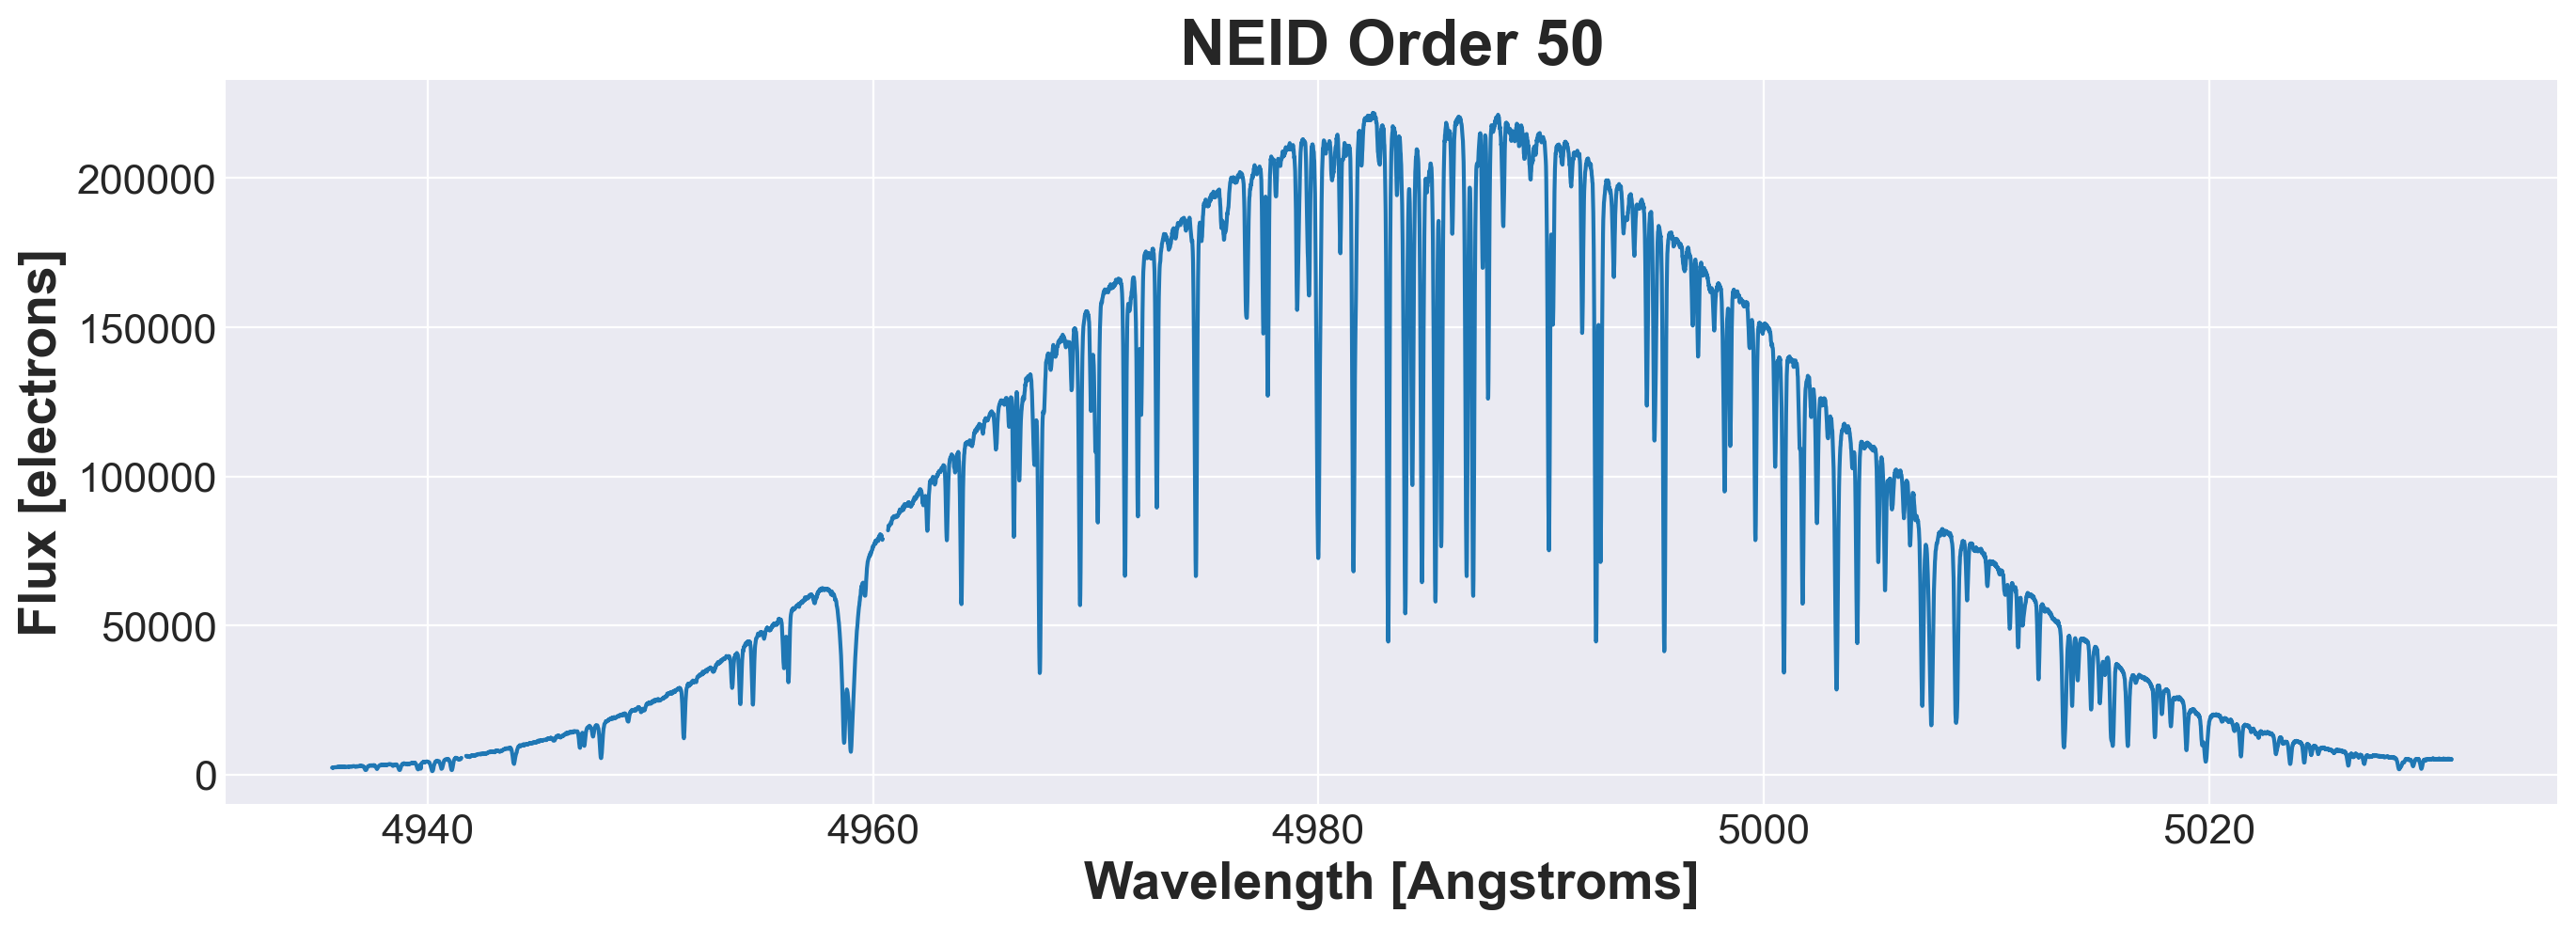

In [146]:
order = 50
plt.plot(wave[order,:],flux[order,:])
plt.title('NEID Order {}'.format(order))
plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Flux [electrons]')
plt.show()

Beautiful! You can see the many absorption lines in this wavelength range for the Sun. The overall shape of the order is dictated by the "blaze function" of the echelle grating that is the primary disperser in NEID. You will also notice that we have lots of counts, even though this is a ~1 minute exposure, because the Sun is our brightest target.

Now let's try to plot all the order and see how the star behaves over the wide wavelength range of NEID. Since there are so many orders, we will plot this in a loop. We will also set the colors to be used, to reflect the underlying wavelengths in the spectrum.

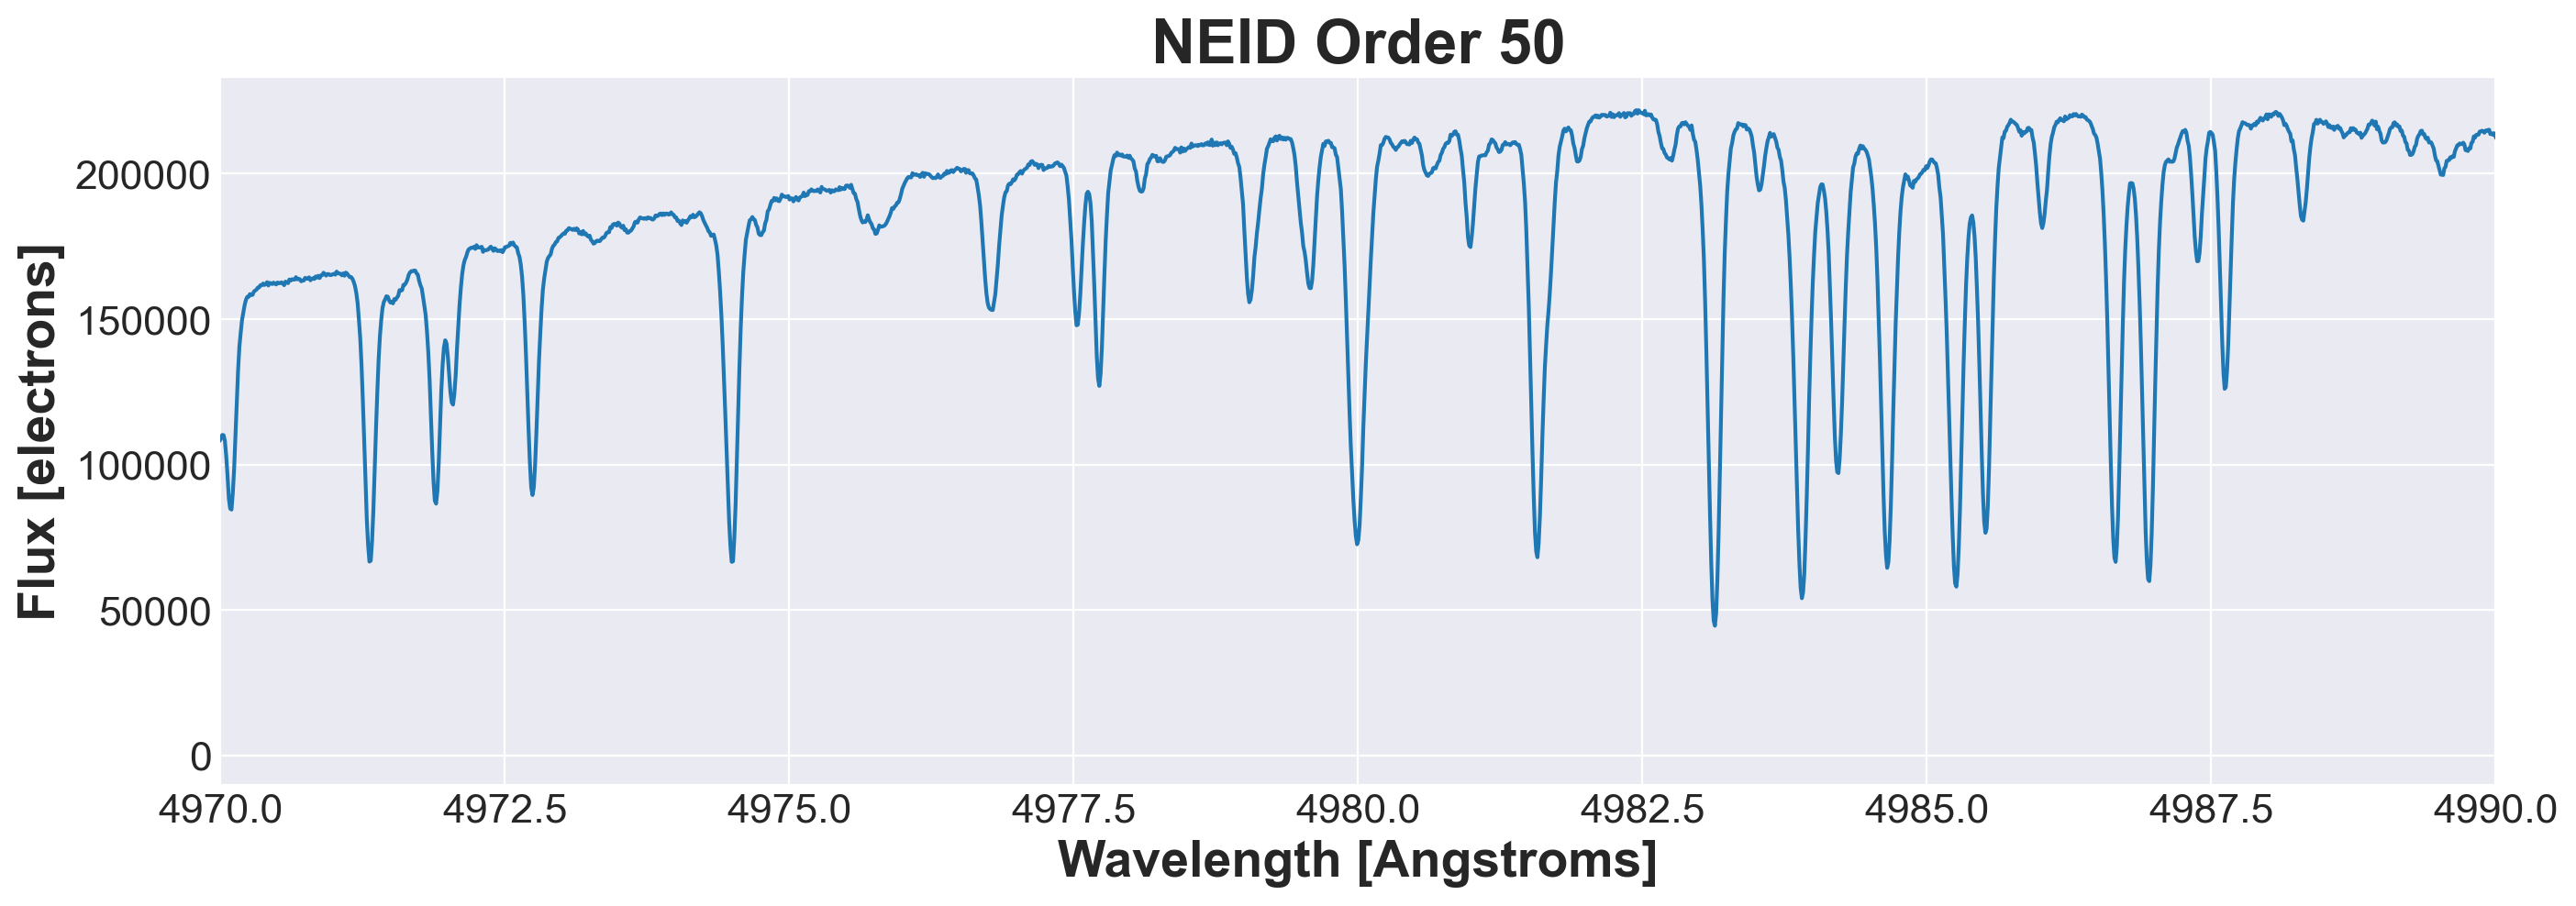

In [153]:
order = 50
plt.plot(wave[order,:],flux[order,:])
plt.title('NEID Order {}'.format(order))
plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Flux [electrons]')
plt.xlim(4970,4990)
plt.show()

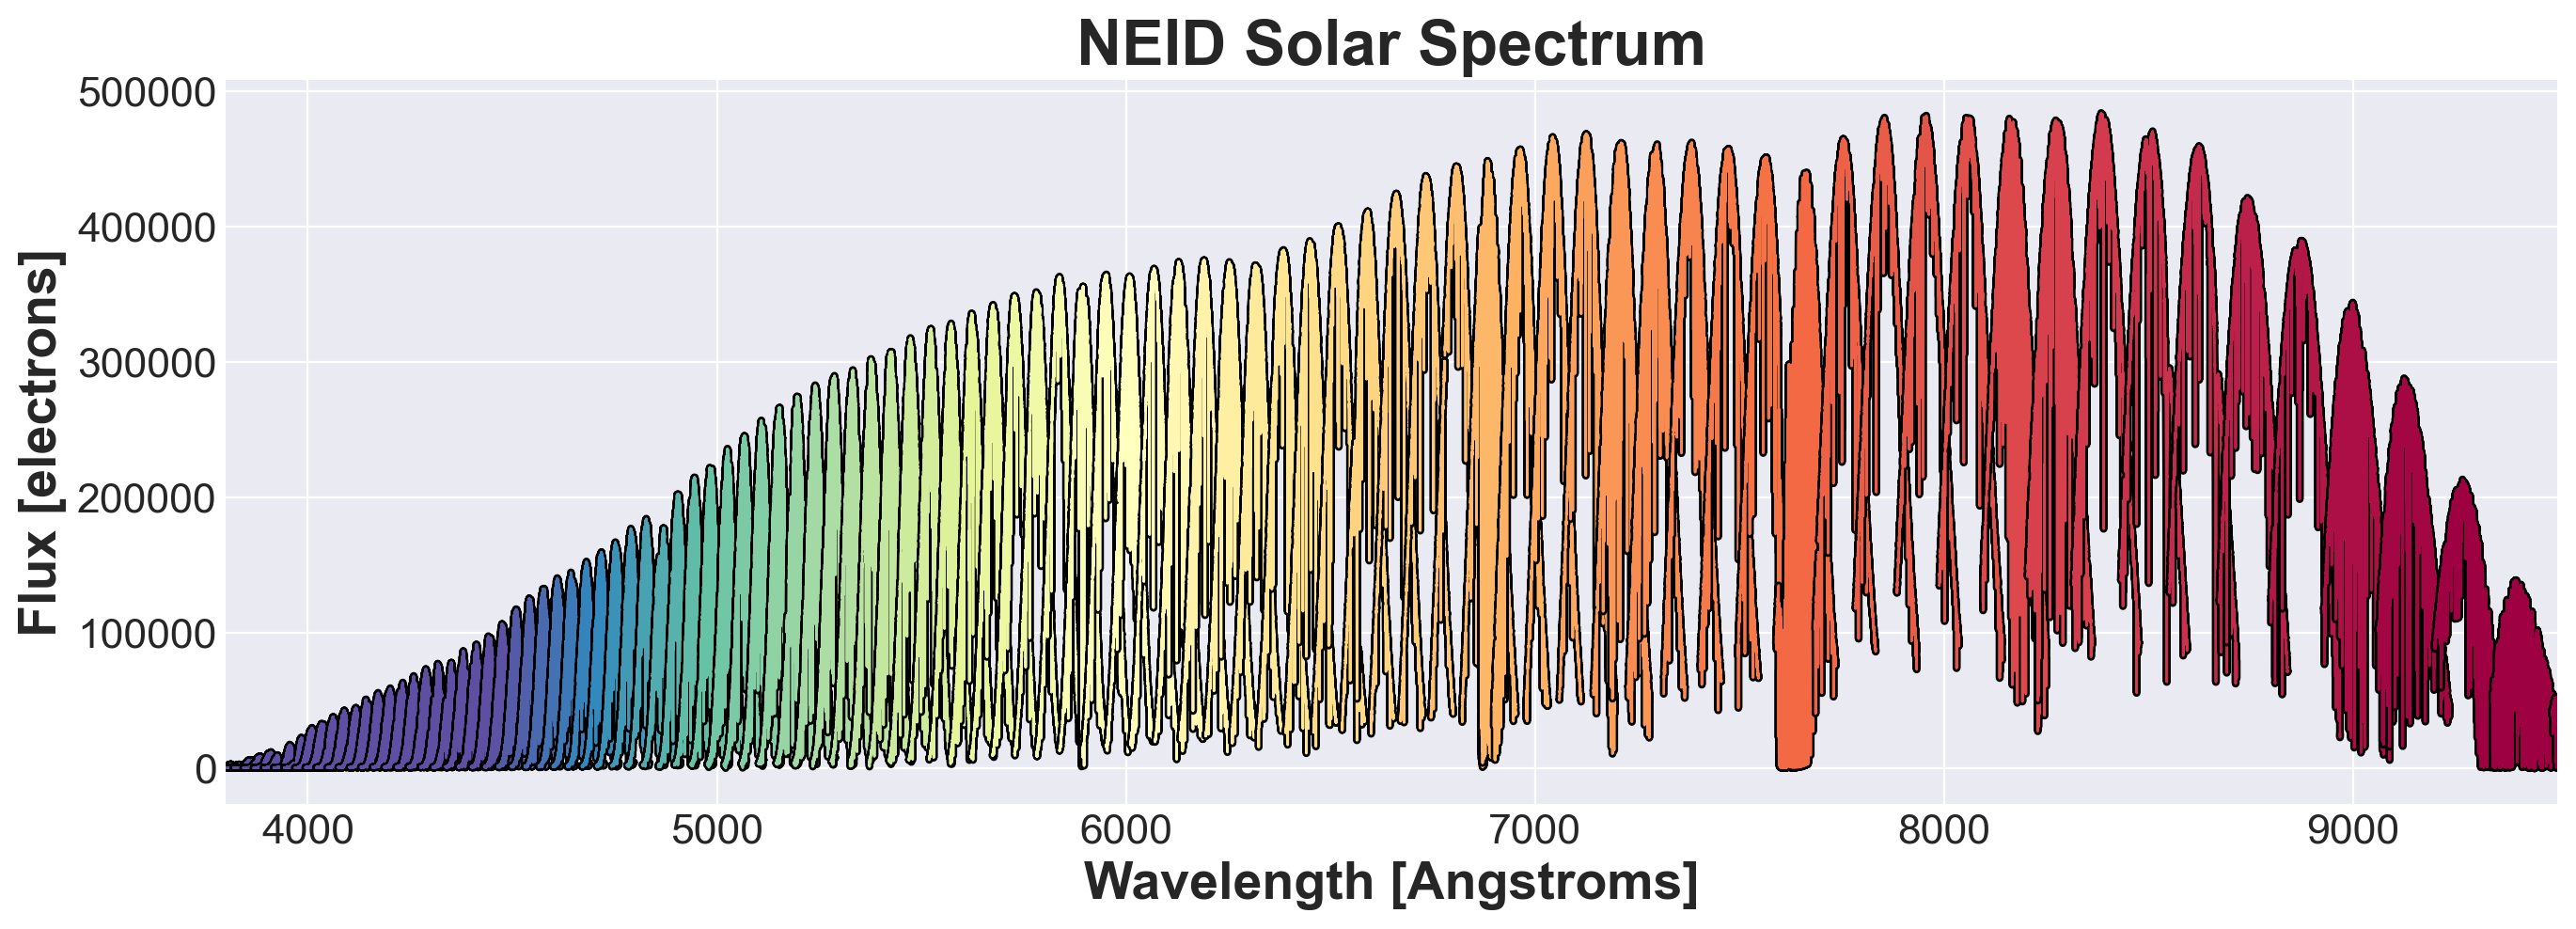

In [147]:
norders = flux.shape[0]

# Sort out color map
cmap = plt.get_cmap('Spectral_r')
mycolors = cmap(np.linspace(-0.5, 1.2, norders))

fig, ax = plt.subplots(figsize=(16,5))

for order in range(norders):
    ax.plot(wave[order,:],flux[order,:],c='black',lw=3)
    ax.plot(wave[order,:],flux[order,:],c=mycolors[order], lw=1)

ax.set_title('NEID Solar Spectrum'.format(order))
ax.set_xlabel('Wavelength [Angstroms]')
ax.set_ylabel('Flux [electrons]')
ax.set_xlim(3800,9500)
plt.show()

### 3. Get Radial Velocity Values<a class="anchor" id="getrv"></a>

The radial velocity (RV) measurement, which is the final product from each observation, is also stored in the L2 files. Specifically, these are in the headers of the `CCFS` extension. Let's take a look at the full header first.

In [140]:
hdul['CCFS'].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  804                                                  
NAXIS2  =                  122                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
CTYPE1  = 'km/s    '           / Pixel coordinate system in x                   
CTYPE2  = 'e-      '           / Pixel coordinate system in y                   
CCFSTART=               -100.0 / Start of RV range (km/s)                       
CCFSTEP =                 0.25 / Step of RV range (km/s)                        
MAXCPP  =    5010849.664593624 / Max count/pixel of CCF)                        
CCFLINES=                 55

Now let's pull out some values we care about: the final RV and time of observation. There are 2 final RVs in the header, `CCFSUM` is the naively combined RV of all the orders, while `CCFRVMOD` is a more sophisticated combination that corrects out differences due to observing conditions.

We will use `CCFRVMOD`, and the corresponding time of observation, `CCFJDMOD`. Note that the time is recorded in [Julian Days](https://en.wikipedia.org/wiki/Julian_day#:~:text=The%20Julian%20day%20is%20the,date%20and%20sell%20by%20date) -- a system commonly used in astronomy. Here the time of observation is already corrected for Earth's motion relative to the Sun, and formally in units of BJD-TDB.

In [149]:
# Quick look
hdul['CCFS'].header['CCFRVMOD']

-0.6403652439391726

In [150]:
# Nicely formatted print statements
print('Radial velocity of this observation is {} km/s.'.format(hdul['CCFS'].header['CCFRVMOD']))
print('Time of this observation is {} BJD.'.format(hdul['CCFS'].header['CCFJDMOD']))

Radial velocity of this observation is -0.6403652439391726 km/s.
Time of this observation is 2459254.294322899 BJD.
